In [20]:
# If running locally, uncomment the next line
# !pip install pandas numpy scikit-learn xgboost joblib matplotlib

import os
import joblib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,make_scorer, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [21]:
df = pd.read_csv("Crop_recommendation.csv")  # 22 crops, 7 features + label
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [22]:
#Quick checks
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nLabel distribution (top 10):\n", df['label'].value_counts().head(10))
df.describe(include='all').T


Shape: (2200, 8)

Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

Missing values per column:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Label distribution (top 10):
 label
rice          100
maize         100
jute          100
cotton        100
coconut       100
papaya        100
orange        100
apple         100
muskmelon     100
watermelon    100
Name: count, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
N,2200.0,NaN,NaN,NaN,50.551818,36.917334,0.0,21.0,37.0,84.25,140.0
P,2200.0,NaN,NaN,NaN,53.362727,32.985883,5.0,28.0,51.0,68.0,145.0
K,2200.0,NaN,NaN,NaN,48.149091,50.647931,5.0,20.0,32.0,49.0,205.0
temperature,2200.0,NaN,NaN,NaN,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,NaN,NaN,NaN,71.481779,22.263812,14.25804,60.261953,80.473146,89.948771,99.981876
ph,2200.0,NaN,NaN,NaN,6.46948,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,NaN,NaN,NaN,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117
label,2200,22,rice,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#split and encode labels for XGBoost
FEATURES = ['N','P','K','temperature','humidity','ph','rainfall']
TARGET = 'label'

X = df[FEATURES].copy()
y_str = df[TARGET].copy()

# Encode labels to integers for XGBoost; we’ll map back later
le = LabelEncoder()
y = le.fit_transform(y_str)

# Keep class names for reports
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Num classes:", len(class_names))


Train size: (1760, 7)  Test size: (440, 7)
Num classes: 22


In [24]:
#Train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1  = f1_score(y_test, rf_pred, average='macro')

print(f"Random Forest  | Accuracy: {rf_acc:.4f} | Macro-F1: {rf_f1:.4f}")
print("\nClassification Report (RF):\n",
      classification_report(y_test, rf_pred, target_names=class_names, digits=4))


Random Forest  | Accuracy: 0.9932 | Macro-F1: 0.9932

Classification Report (RF):
               precision    recall  f1-score   support

       apple     1.0000    1.0000    1.0000        20
      banana     1.0000    1.0000    1.0000        20
   blackgram     1.0000    0.9500    0.9744        20
    chickpea     1.0000    1.0000    1.0000        20
     coconut     1.0000    1.0000    1.0000        20
      coffee     1.0000    1.0000    1.0000        20
      cotton     1.0000    1.0000    1.0000        20
      grapes     1.0000    1.0000    1.0000        20
        jute     0.9524    1.0000    0.9756        20
 kidneybeans     1.0000    1.0000    1.0000        20
      lentil     1.0000    0.9500    0.9744        20
       maize     0.9524    1.0000    0.9756        20
       mango     1.0000    1.0000    1.0000        20
   mothbeans     0.9524    1.0000    0.9756        20
    mungbean     1.0000    1.0000    1.0000        20
   muskmelon     1.0000    1.0000    1.0000        2

In [25]:
#Train XGBoost
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(class_names),
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # fast on CPU, ok on GPU too
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1  = f1_score(y_test, xgb_pred, average='macro')

print(f"XGBoost        | Accuracy: {xgb_acc:.4f} | Macro-F1: {xgb_f1:.4f}")
print("\nClassification Report (XGB):\n",
      classification_report(y_test, xgb_pred, target_names=class_names, digits=4))


XGBoost        | Accuracy: 0.9909 | Macro-F1: 0.9908

Classification Report (XGB):
               precision    recall  f1-score   support

       apple     1.0000    1.0000    1.0000        20
      banana     1.0000    1.0000    1.0000        20
   blackgram     0.9524    1.0000    0.9756        20
    chickpea     1.0000    1.0000    1.0000        20
     coconut     1.0000    1.0000    1.0000        20
      coffee     1.0000    1.0000    1.0000        20
      cotton     1.0000    1.0000    1.0000        20
      grapes     1.0000    1.0000    1.0000        20
        jute     0.9524    1.0000    0.9756        20
 kidneybeans     1.0000    1.0000    1.0000        20
      lentil     1.0000    0.9000    0.9474        20
       maize     1.0000    1.0000    1.0000        20
       mango     1.0000    1.0000    1.0000        20
   mothbeans     0.9524    1.0000    0.9756        20
    mungbean     0.9524    1.0000    0.9756        20
   muskmelon     1.0000    1.0000    1.0000        

In [26]:
# Precision, Recall (Macro)
rf_precision = precision_score(y_test, rf_pred, average='macro')
rf_recall    = recall_score(y_test, rf_pred, average='macro')

xgb_precision = precision_score(y_test, xgb_pred, average='macro')
xgb_recall    = recall_score(y_test, xgb_pred, average='macro')

# ROC-AUC for multi-class (One-vs-Rest)
rf_auc  = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr')

extra_metrics = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [rf_acc, xgb_acc],
    "Precision": [rf_precision, xgb_precision],
    "Recall": [rf_recall, xgb_recall],
    "Macro F1": [rf_f1, xgb_f1],
    "ROC-AUC": [rf_auc, xgb_auc]
}).round(4)

print("🔎 Extended Model Evaluation Metrics:")
display(extra_metrics)

🔎 Extended Model Evaluation Metrics:


,Model,Accuracy,Precision,Recall,Macro F1,ROC-AUC
0,Random Forest,0.9932,0.9935,0.9932,0.9932,1.0
1,XGBoost,0.9909,0.9913,0.9909,0.9908,1.0


===== 5-Fold Cross-Validation Summary =====


,Model,Train Accuracy Mean,Test Accuracy Mean,Test Accuracy Std,Train F1 Mean,Test F1 Mean
0,RandomForest (Tuned),1.0,0.9950,0.0027,1.0,0.9950
1,XGBoost (Tuned),1.0,0.9941,0.0034,1.0,0.9941


C:\Users\nlsan\AppData\Local\Temp\ipykernel_10512\1371602396.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


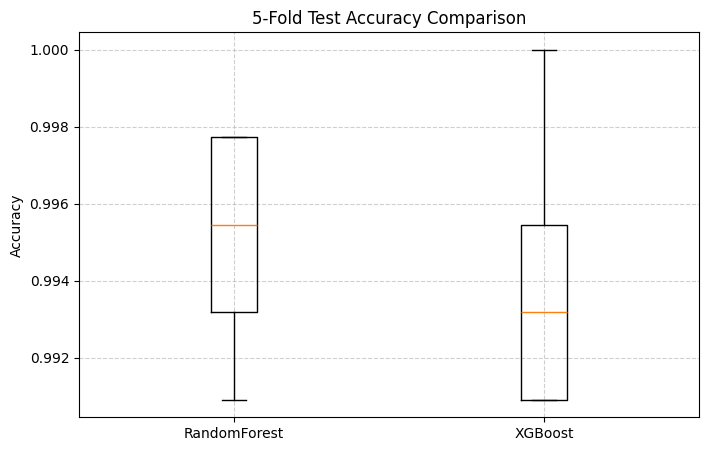

🌟 Best generalized model after cross-validation: RandomForest (Tuned)


In [27]:

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro')
}

#Perform Cross-Validation
rf_cv = cross_validate(rf, X, y, cv=cv, scoring=scoring, return_train_score=True)
xgb_cv = cross_validate(xgb, X, y, cv=cv, scoring=scoring, return_train_score=True)

#Summarize Results
results = pd.DataFrame({
    'Model': ['RandomForest (Tuned)', 'XGBoost (Tuned)'],
    'Train Accuracy Mean': [rf_cv['train_accuracy'].mean(), xgb_cv['train_accuracy'].mean()],
    'Test Accuracy Mean': [rf_cv['test_accuracy'].mean(), xgb_cv['test_accuracy'].mean()],
    'Test Accuracy Std': [rf_cv['test_accuracy'].std(), xgb_cv['test_accuracy'].std()],
    'Train F1 Mean': [rf_cv['train_macro_f1'].mean(), xgb_cv['train_macro_f1'].mean()],
    'Test F1 Mean': [rf_cv['test_macro_f1'].mean(), xgb_cv['test_macro_f1'].mean()],
})

print("===== 5-Fold Cross-Validation Summary =====")
display(results.round(4))

# Visualize Cross-Validation Scores
plt.figure(figsize=(8,5))
plt.boxplot(
    [rf_cv['test_accuracy'], xgb_cv['test_accuracy']],
    labels=['RandomForest', 'XGBoost']
)
plt.title("5-Fold Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Choose Best Model
best_model_name = results.loc[results['Test Accuracy Mean'].idxmax(), 'Model']
print(f"🌟 Best generalized model after cross-validation: {best_model_name}")


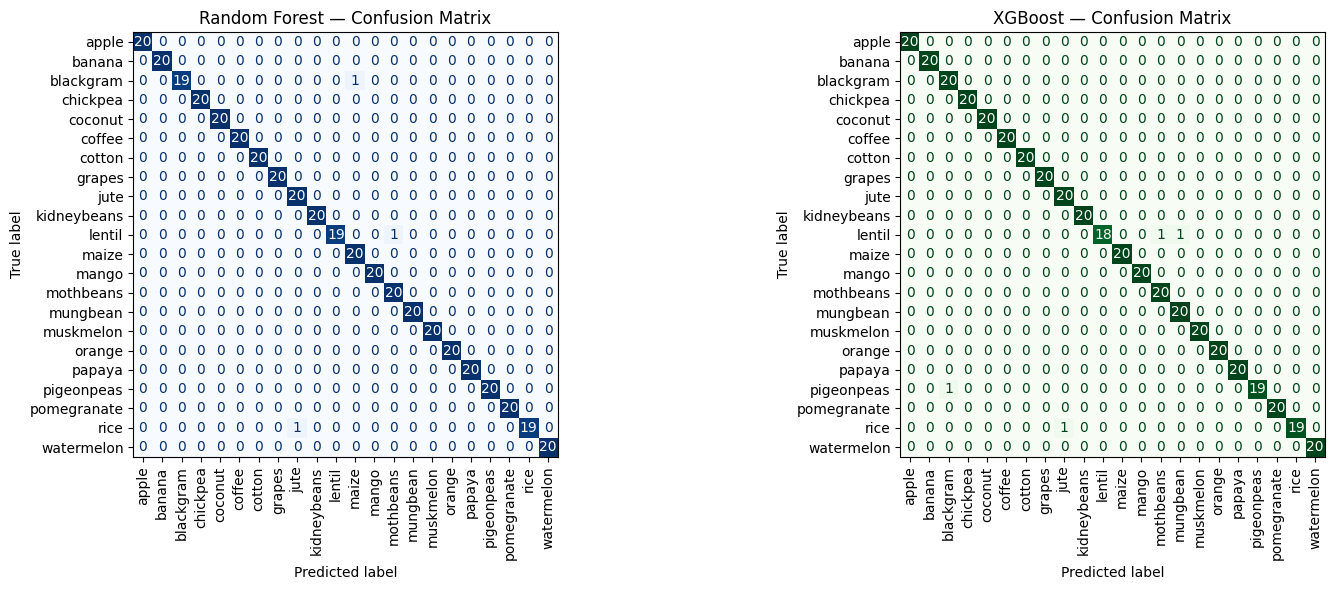

In [28]:
#Confusion Matrices of Random Forest and XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_rf = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(cm_rf, display_labels=class_names).plot(
    ax=axes[0], values_format='d', cmap='Blues', colorbar=False
)
axes[0].set_title("Random Forest — Confusion Matrix")
axes[0].tick_params(axis='x', rotation=90)

cm_xgb = confusion_matrix(y_test, xgb_pred)
ConfusionMatrixDisplay(cm_xgb, display_labels=class_names).plot(
    ax=axes[1], values_format='d', cmap='Greens', colorbar=False
)
axes[1].set_title("XGBoost — Confusion Matrix")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [29]:
#Feature Importance(showing from the best model)
# Pick best by macro-F1 (tie-breaker: accuracy)
if (xgb_f1 > rf_f1) or (xgb_f1 == rf_f1 and xgb_acc >= rf_acc):
    best_name = "XGBoost"
    best_model = xgb
    importances = best_model.feature_importances_
else:
    best_name = "RandomForest"
    best_model = rf
    importances = best_model.feature_importances_

imp_df = pd.DataFrame({"feature": FEATURES, "importance": importances}) \
           .sort_values("importance", ascending=False)

print(f"Best model: {best_name}")
imp_df


Best model: RandomForest


,feature,importance
6,rainfall,0.221528
4,humidity,0.211936
2,K,0.179170
1,P,0.153670
0,N,0.103911
3,temperature,0.075844
5,ph,0.053941


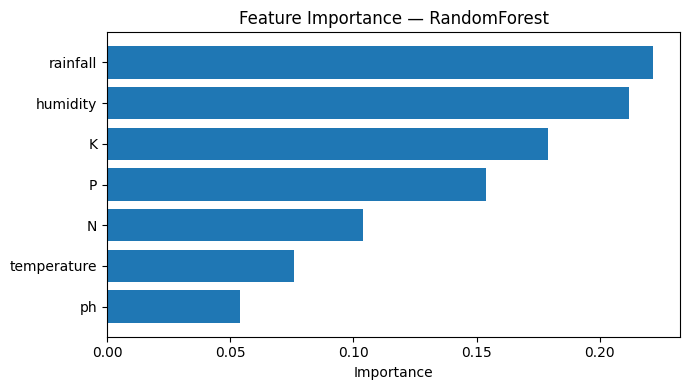

In [30]:
plt.figure(figsize=(7,4))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title(f"Feature Importance — {best_name}")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [31]:
#save best model+Meta data
os.makedirs("models", exist_ok=True)
artifact = {
    "model": best_model,
    "label_encoder": le,
    "features": FEATURES,
    "class_names": class_names,
    "algo": best_name,
    "metrics": {
        "rf": {"accuracy": rf_acc, "macro_f1": rf_f1},
        "xgb": {"accuracy": xgb_acc, "macro_f1": xgb_f1}
    }
}
joblib.dump(artifact, f"models/best_crop_model.joblib")
print("Saved → models/best_crop_model.joblib")


Saved → models/best_crop_model.joblib


In [32]:
import os, joblib

os.makedirs("models", exist_ok=True)  # create folder if not present
joblib.dump(rf, "models/RandomForest_crop_model.pkl")

print("✅ Random Forest model saved at models/RandomForest_crop_model.pkl")


✅ Random Forest model saved at models/RandomForest_crop_model.pkl


In [33]:
artifact = {
    "model": rf,
    "label_encoder": le,
    "features": X.columns.tolist()
}

os.makedirs("models", exist_ok=True)
joblib.dump(artifact, "models/RandomForest_crop_model.pkl")

print("✅ Saved Random Forest model + label encoder")

✅ Saved Random Forest model + label encoder


In [ ]:

# Accuracy data
data = {
    "Model": ["Random Forest", "XGBoost"],
    "Base Paper Accuracy": [99.31, 98.20],
    "Proposed System Accuracy": [99.50, 99.41]
}

df = pd.DataFrame(data)

# Plot configuration
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")

# Grouped bar chart
bar = sns.barplot(
    x="Model",
    y="value",
    hue="variable",
    data=pd.melt(df, ["Model"]),
    palette=["#6495ED", "#2E8B57"]
)

plt.title("Comparison of Model Accuracy: Base Paper vs Proposed Work", fontsize=13, weight='bold')
plt.ylabel("Accuracy (%)")
plt.xlabel("Machine Learning Model")
plt.ylim(95, 100)
plt.legend(title="Source", loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add labels on top of bars
for container in bar.containers:
    bar.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)

plt.tight_layout()
plt.show()


In [34]:
#Quick Single Prediction Helper (sanity check)
def predict_one(model_artifact, N,P,K,temperature,humidity,ph,rainfall):
    FEATURES = model_artifact["features"]
    X_one = pd.DataFrame([[N,P,K,temperature,humidity,ph,rainfall]], columns=FEATURES)
    proba = model_artifact["model"].predict_proba(X_one)[0]
    idx_sorted = np.argsort(proba)[::-1]
    top3 = [(model_artifact["class_names"][i], float(proba[i])) for i in idx_sorted[:3]]
    return top3


artifact_loaded = joblib.load("models/best_crop_model.joblib")
predict_one(artifact_loaded, 90, 42, 43, 20.0, 80.0, 6.5, 200.0)  # example


[('rice', 0.86),
 ('jute', 0.13333333333333333),
 ('watermelon', 0.0033333333333333335)]

In [35]:
# Simple backend test for fertilizer logic (no manual input)

# Example input values (you can also take them dynamically)
N, P, K, temperature, humidity, ph, rainfall = 90, 42, 43, 20.0, 80.0, 6.5, 200.0

# Predict crop name using trained model
pred_result = predict_one(artifact_loaded, N, P, K, temperature, humidity, ph, rainfall)
crop_name = pred_result[0][0]   # top-1 crop
print(f"🌾 Recommended Crop: {crop_name}")

# Get ideal N, P, K levels for that crop (mean values from dataset)
ideal = df[df['label'] == crop_name][['N','P','K']].mean()

# Compute differences
diff_N = round(ideal['N'] - N, 1)
diff_P = round(ideal['P'] - P, 1)
diff_K = round(ideal['K'] - K, 1)

# Define suggestion logic
def fert_suggestion(n, p, k):
    recs = []
    if n > 0:
        recs.append(f"🟢 Add {abs(int(n))} kg/acre Nitrogen (Urea)")
    elif n < 0:
        recs.append(f"🔴 Reduce {abs(int(n))} kg/acre Nitrogen fertilizer")

    if p > 0:
        recs.append(f"🟢 Add {abs(int(p))} kg/acre Phosphorus (DAP)")
    elif p < 0:
        recs.append(f"🔴 Reduce {abs(int(p))} kg/acre Phosphorus fertilizer")

    if k > 0:
        recs.append(f"🟢 Add {abs(int(k))} kg/acre Potassium (MOP)")
    elif k < 0:
        recs.append(f"🔴 Reduce {abs(int(k))} kg/acre Potassium fertilizer")
    return recs

# Generate recommendations
fert_recs = fert_suggestion(diff_N, diff_P, diff_K)

print("\n🧪 Fertilizer Recommendations:")
for rec in fert_recs:
    print(rec)

🌾 Recommended Crop: rice

🧪 Fertilizer Recommendations:
🔴 Reduce 10 kg/acre Nitrogen fertilizer
🟢 Add 5 kg/acre Phosphorus (DAP)
🔴 Reduce 3 kg/acre Potassium fertilizer


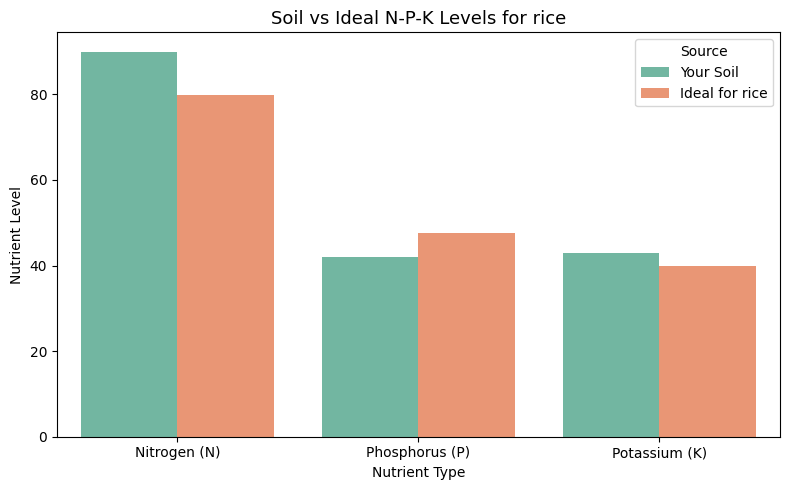

In [36]:
# Create comparison DataFrame
comp_df = pd.DataFrame({
    "Nutrient": ["Nitrogen (N)", "Phosphorus (P)", "Potassium (K)"],
    "Your Soil": [N, P, K],
    f"Ideal for {crop_name}": [ideal['N'], ideal['P'], ideal['K']]
})

# Melt the DataFrame for grouped plotting
comp_melt = comp_df.melt(id_vars="Nutrient", var_name="Source", value_name="Value")

# Plot using Seaborn
plt.figure(figsize=(8,5))
sns.barplot(data=comp_melt, x="Nutrient", y="Value", hue="Source", palette="Set2")
plt.title(f"Soil vs Ideal N-P-K Levels for {crop_name}", fontsize=13)
plt.ylabel("Nutrient Level")
plt.xlabel("Nutrient Type")
plt.legend(title="Source", loc="best")
plt.tight_layout()
plt.show()